
сталь
E_m = 200000000000.0, nu_m = 0.27, E_p = 190000000.0, nu_p = 0.43, r_p = 8e-05, v_p = 15, rho_p = 900

k_m = 1.4755254774049619e-12 
k_p = 1.365549411728462e-09 
m_p = 1.930194526365569e-09 
delta_pm = 2776881.9682133393 
s_0 = 8.250010023015714e-06 
tau_0 = 1.6170019645110796e-06


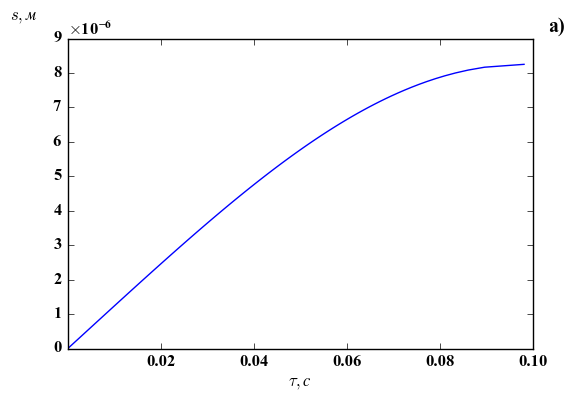

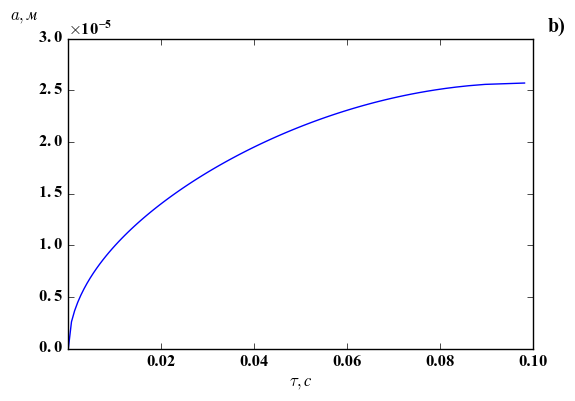

In [8]:
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import numpy as num
import matplotlib.ticker as tck

# Constants
polyethylene_E = 0.19e9
polyethylene_nu = 0.43
steel_E = 200e9
steel_nu = 0.27
wood_E = 8e9
wood_nu = 0.5

# Config
class Config:
    def __init__(self, name = None, E_m = 0, nu_m = 0, E_p = 0, nu_p = 0, r_p = 0, v_p = 0, rho_p = 0):
        self.name = name
        self.E_m = E_m
        self.nu_m = nu_m
        self.E_p = E_p
        self.nu_p = nu_p
        self.r_p = r_p
        self.v_p = v_p
        self.rho_p = rho_p
    
# Config factory for steel and other materials
class ConfigFactory: 
    
    def createBaseConfig():
        r_p = 8e-5
        v_p = 15
        rho_p = 900
        return Config(name = None, E_p = polyethylene_E, nu_p = polyethylene_nu, 
                      r_p = r_p, v_p = v_p, rho_p = rho_p)
    
    def createSteelConfig():
        config = ConfigFactory.createBaseConfig()
        config.name = "сталь"
        config.E_m = steel_E
        config.nu_m = steel_nu
        return config
    
    def createPolyethyleneConfig():
        config = ConfigFactory.createBaseConfig()
        config.E_m = polyethylene_E
        config.nu_m = polyethylene_nu
        return config
    
    def createWoodConfig():
        config = ConfigFactory.createBaseConfig()
        config.name = "дерево"
        config.E_m = wood_E
        config.nu_m = wood_nu
        return config

# Functions
class Functions:
    def k(E, nu):
        return (1-nu**2)/(num.pi*E)

    def delta_pm(r_p, k_p, k_m):
        return 4*num.sqrt(r_p)/(3*num.pi*(k_p+k_m))

    def s_0(m_p, v_p, delta_pm):
        return num.power(5*m_p*v_p**2/(4*delta_pm), 0.4)

    def m(V, rho):
        return V*rho

    def sphereV(r):
        return 4./3*num.pi*r**3
    
    def tau(s, s_0, v_p):
        return 1/v_p*integrate.quad(lambda t: 1/num.sqrt(1-num.power(t,2.5)), 0, s/s_0)[0]
    
    def s_approx(tau, v_p):
        return v_p*tau
    
    def tau_0(m_p, v_p, delta_pm):
        return 2.94*num.power(5*m_p/(4*delta_pm*num.sqrt(v_p)), 0.4)
    
    def a(k_p, k_m, r_p, P):
        return num.power(3*num.pi*(k_p+k_m)*r_p*P/4, 1./3)
    
    def P(delta_pm, s):
        return delta_pm*num.power(s, 1.5)

# Task
class Task:
    def plot(config, xarr, yarr, xlabel, ylabel, title):
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 12
        plt.rcParams["font.style"] = "normal"
        
        fig, ax = plt.subplots()
        formatter = tck.ScalarFormatter(useMathText=True, useOffset=True)
        formatter.set_powerlimits((0,0))
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_label_coords(-0.095, 1.045)
        plt.title(title, x=1.05)
        plt.ylabel(ylabel,rotation=0)
        plt.xlabel(xlabel)
        plt.plot(xarr, yarr, label = config.name)
        xticks = ax.xaxis.get_major_ticks()
        xticks[0].label1.set_visible(False)
        plt.show()         
        
    def calc(config, log):
        E_m = config.E_m
        nu_m = config.nu_m
        E_p = config.E_p
        nu_p = config.nu_p
        r_p = config.r_p
        v_p = config.v_p
        rho_p = config.rho_p
        
        print("\n{0}".format(config.name))
        print("E_m = {0}, nu_m = {1}, E_p = {2}, nu_p = {3}, r_p = {4}, v_p = {5}, rho_p = {6}".
              format(E_m, nu_m, E_p, nu_p, r_p, v_p, rho_p))
        
        k_m = Functions.k(E_m, nu_m)
        k_p = Functions.k(E_p, nu_p)
        m_p = Functions.m(Functions.sphereV(r_p), rho_p)
        delta_pm = Functions.delta_pm(r_p, k_p, k_m)
        s_0 = Functions.s_0(m_p, v_p, delta_pm)
        tau_0 = Functions.tau_0(m_p, v_p, delta_pm)
        
        print("\nk_m = {0} \nk_p = {1} \nm_p = {2} \ndelta_pm = {3} \ns_0 = {4} \ntau_0 = {5}".
              format(k_m, k_p, m_p, delta_pm, s_0, tau_0))
        
        n = 100
        arr_s = num.linspace(0, s_0, n)
        arr_tau = list(map(lambda s: Functions.tau(s, s_0, v_p), arr_s))
        arr_s_approx = list(map(lambda tau: Functions.s_approx(tau, v_p), arr_tau))
        
        arr_P = list(map(lambda s: Functions.P(delta_pm, s), arr_s))
        arr_a = list(map(lambda P: Functions.a(k_p, k_m, r_p, P), arr_P))
        return (arr_tau, arr_s, arr_a)
    
    def start(configs):
        for config in configs:
            arr_tau, arr_s, arr_a = Task.calc(config, True)
            Task.plot(config, arr_tau, arr_s, r'$\tau, с$', r'$s,  м$', "a)")
            Task.plot(config, arr_tau, arr_a, r'$\tau, с$', r'$a,  м$', "b)")
    
# Program
configs = [ConfigFactory.createSteelConfig()]
Task.start(configs)
        